In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize

# uncomment to make plots interactive
# %matplotlib notebook

# Fit a visibility function to some results from fringes
This notebook gives an example of how to input some visibility data and fit a function to obtain a source size.

## Read in the fitted data

Create a list of your fits files in a text file which is in the same folder as the data. Each line has the baseline length in mm, the filter, and the file name. The quick way to do this is to take images in a systematic order, e.g. all baselines in one filter, then all baselines in the next filter, etc.

The file looks something like this:
```
2 r image1.fits
3 g image2.fits
0.6 b image3.fits
```
The code below figures out from the path to the text file where the fits and save files are.

This method is preferred, since we can also plot how the fringe spacing compares with the wavelength and baseline; if something was labelled incorrectly this can be spotted here.

See the end of this notebook for a cell where you can put the visibility values in by hand.

These data show how good the results can be!

In [2]:
textfile = '../testdata/single_2mm/files.txt'

# you will need a line something like this, that goes up two
# directory levels and then to wherever you have saved the images
# textfile = '../../Data/single_2mm/files.txt'

path = os.path.dirname(textfile)

# wavelengths for red, green, blue
lam = np.array([615, 530, 455]) * 1e-9
u_all = np.array([])
v_all = np.array([])
b_all = np.array([])
w_all = np.array([])
wav_all = np.array([])

for l in open(textfile, 'r'):

    # extract the info from the line
    b, filt, file = l.split()
    b_all = np.append(b_all, float(b))
    file = file.rstrip()

    # convert filter name to wavelength
    if filt == 'r': wav = lam[0]
    if filt == 'g': wav = lam[1]
    if filt == 'b': wav = lam[2]
    wav_all = np.append(wav_all, wav)
    
    # get b/lambda
    u_all = np.append(u_all, float(b)/wav/1e3)

    # uncomment one or other of below lines

    # get visibility from image fitting
    # (and fitted wavelengths for sanity checking)
    par = np.load(path + '/' + os.path.splitext(file)[0]+'-params.npy')
    vis_ = par[6]
    w_all = np.append(w_all, par[2])

    # uncomment to use visibility from saved FT results
#     vis_ = np.load(path + '/' + os.path.splitext(file)[0]+'-FTparams.npy')

    v_all = np.append(v_all, vis_)

### Sanity check baselines and wavelengths
This plot shows the expected fringe spacing ($\lambda/b$) divided by the measured fringe spacing from the fitting. Dots are coloured by their baseline, so should appear in triplets (one for each wavelength).

The values in this plot should be roughly constant, within about 10% of each other. Ratios that are a long way off the others indicate poor fitting (expected for small $\lambda/b$ where visibilities are very small and hard to fit), or other issues (e.g. incorrectly recorded baseline).

Some variation as seen in the example is OK, these indicate systematic uncertainties, for example that the actual baseline lengths differ somewhat from those given in the lab script (e.g. the 1mm hole, which is the second from right set of three points that are quite low) is probably a little smaller). The main point here is to help diagnose issues if the visibility fit below looks poor and has systematic offsets for some data.

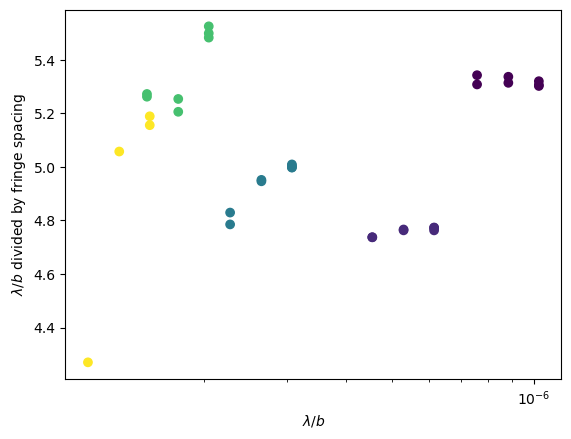

In [3]:
fig, ax = plt.subplots()
ax.scatter(wav_all/b_all, 1e9*wav_all/b_all/w_all, c=b_all)
ax.set_xlabel('$\\lambda/b$')
ax.set_ylabel('$\\lambda/b$ divided by fringe spacing')
ax.set_xscale('log')

## Manual data entry
Here is where you would enter data by hand, similar to the last cell in this notebook, or from the 3-hole notebook.

In [4]:
# manual data entered here

## Now write a function that we will fit
The first function returns the absolute value of the visibility (we cannot measure negative values, and are not dealing with phases here) for some input parameters $p$, which are
- p[0]: the peak of the function at zero baseline, this might not be exactly 1
- p[1]: the angular size in radians of the source

The second function computes the $\chi^2$, though here we have no uncertainties on the visibility measurements so there is no denominator. This function uses the data `v_all` defined above, so this is a global variable and we do not need to pass it to the function.

In [5]:
def vis(p, u):
    return np.abs( 2 * p[0] * scipy.special.jv(1, np.pi*u*p[1]) / (np.pi*u*p[1]) )

def chi2_vis(p, u):
    return np.sum( (v_all - vis(p, u))**2 )

def vis_curve_fit(u, p0, p1):
    return vis( [p0, p1], u)

## Do the fitting
There are various minimisation codes we might use, some take a 'merit function' as input, such as one that computes a $\chi^2$, where others take a function that computes y values given some x. In choosing a function it's useful to use one that can incorporate uncertainties and give estimated uncertainties on the output parameters.

`scipy.optimize.minimize` takes as input the name of the function we are minimising (`chi2_vis`) and some initial guesses for the two parameters. It also takes the $b/\lambda$ values. It does not necessarily use uncertainties.

`scipy.optimize.curve_fit` takes a function that computes y values for a given x, can take uncertainties, and returns a covariance matrix. We can take the diagonal values of this matrix as estimates of the variance for each fitted parameter.

In [6]:
# run a first fit with minimize
r = scipy.optimize.minimize(chi2_vis, (1,0.0003), args=(u_all), method='Nelder-Mead')
fitted = r['x']

# print the best fit values, the first is the visibility at zero baseline,
# the second the angular size of the source in radians
print(fitted)

[9.63070345e-01 2.45520201e-04]


### Visibility uncertainties
With an initial fit, we can estimate uncertainties from the distribution of measurements around the best-fit model. This assumes that the uncertainty on every measurement is the same, which may not be true, but is a sensible empirical approach.

As long as the fit is a reasonably good approximation of reality, the value is likely to be close to the real uncertainty.

In [7]:
unc = np.std(v_all - vis(fitted, u_all))
print(unc)

v_unc = np.repeat(unc, len(v_all))

0.01574946434919355


In [8]:
# now run a fit that incorporates uncertainties, starting from the previous fit
r = scipy.optimize.curve_fit(vis_curve_fit, u_all, v_all,
                             sigma=v_unc, absolute_sigma=True,
                             p0=fitted )

fitted = r[0]
uncertainty = np.sqrt(r[1].diagonal())

for i in [0,1]:
    print(f'{fitted[i]} +/- {uncertainty[i]}')

0.9631156181544371 +/- 0.005514112262731557
0.0002455139387696662 +/- 1.348894525794313e-06


### Diameter measurement
Now we can convert to a physical diameter at the distance between the front of the telescope and the source aperture. The uncertainty here comes out to be very small, perhaps unrealistically so.

In [9]:
# convert to actual size in mm, assuming distance of 8.4m
d = 8.4

print(f'{fitted[1] * d * 1e3:.3f} +/- {uncertainty[1] * d * 1e3:.3f} mm')

2.062 +/- 0.011 mm


## Plot the results
Here we plot the data and the best fit to the data to check things are sensible, i.e. that the model goes through most of the data.

We can also plot the residuals (`data-model`) divided by their uncertainties, so the residuals are in units of standard deviations. If these look like they are random noise then the model is a good fit.

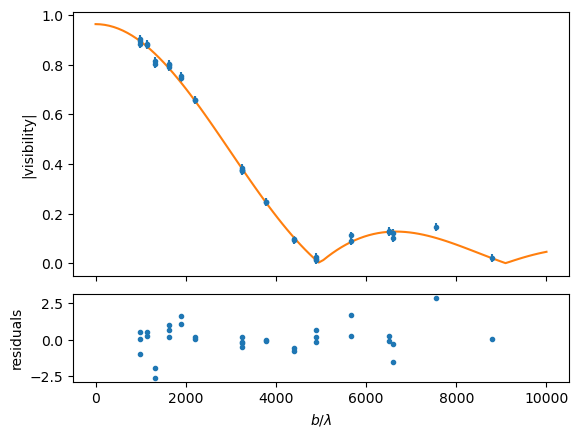

In [10]:
fig, ax = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [3, 1]})
# ax[0].plot(u_r, v_r, '.r')
# ax[0].plot(u_g, v_g, '.g')
# ax[0].plot(u_b, v_b, '.b')
# ax[0].plot(u_all, v_all, 'o')
ax[0].errorbar(u_all, v_all, v_unc, fmt='.')

u = np.linspace(1, 1e4, num=100)
ax[0].plot(u, vis(fitted, u))

ax[1].plot(u_all, (v_all - vis(fitted, u_all))/unc, '.')

ax[1].set_xlabel('$b/\\lambda$')
ax[0].set_ylabel('|visibility|')
ax[1].set_ylabel('residuals')
fig.subplots_adjust(hspace=0.1)

A similar check is whether the distribution looks like it is approximately Gaussian with sigma=1 (bearing in mind that we do not have a lot of data). This is not really as good as the above since systematic variations with baseline are not visible in the histogram.

Text(0, 0.5, 'number')

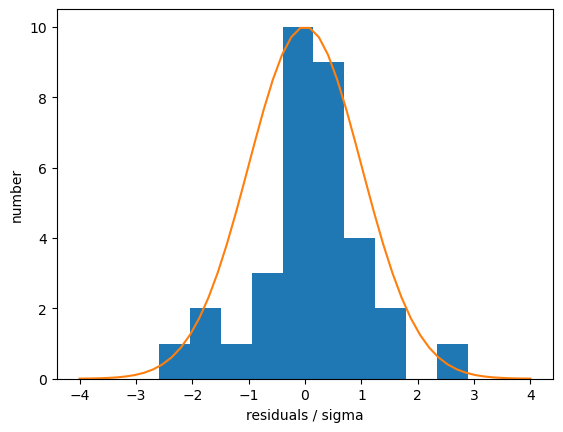

In [11]:
fig, ax = plt.subplots()
ax.hist((v_all - vis(fitted, u_all))/unc, bins=10)

x = np.linspace(-4,4)
ax.plot(x, 10*np.exp(-0.5*x**2))

ax.set_xlabel('residuals / sigma')
ax.set_ylabel('number')

## Manually enter the data into some arrays
An alternative to creating a text file with the fitted results, where the wavelengths and visibilities are entered by hand.

The numbers here are just examples, you will need to change everything!

In [12]:
# baseline lengths
#                 b1   b2   b3   b5    b6
b    = np.array([ 4,  2,  1,   0.6,   3]) * 1e-3

# visibilities
v_r = np.array([0.05,0.24, 0.68,0.77,0.07])
v_g = np.array([0.00,0.127,0.62,0.74,0.099])
v_b = np.array([0.01,0.008,0.46,0.69,0.16])

# wavelengths    r    g    b
lam = np.array([615, 530, 455]) * 1e-9

# get b/lambda (i.e. the x-axis values)
u_b = b/lam[2]
u_g = b/lam[1]
u_r = b/lam[0]

# combine
v_all = np.concatenate((v_r,v_g,v_b))
u_all = np.concatenate((u_r,u_g,u_b))